# AI4Good - Floor Damage Detection Using Deep Learning CNN
> This notebook is used to build a convolutional neural network model that can identify damage areas from undamaged once after the occurance of flood in a region.

In [144]:
import os
import numpy as np
import glob
import shutil
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight


#tf.config.set_visible_devices([], 'GPU')


In [81]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [82]:
tf.test.is_gpu_available()

True

In [83]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [134]:
batch_size = 32
IMG_SHAPE = 150 

In [135]:
train_dir = os.path.abspath(os.path.join('.', 'dataset', 'train'))
val_dir = os.path.abspath(os.path.join('.', 'dataset', 'val'))

In [136]:

image_gen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )
'''
image_gen = ImageDataGenerator(
                    rescale=1./255) '''

train_data_gen = image_gen.flow_from_directory(
                                                batch_size=batch_size,
                                                directory=train_dir,
                                                shuffle=True,
                                                target_size=(IMG_SHAPE,IMG_SHAPE),
                                                class_mode='binary'
                                                )

Found 338 images belonging to 2 classes.


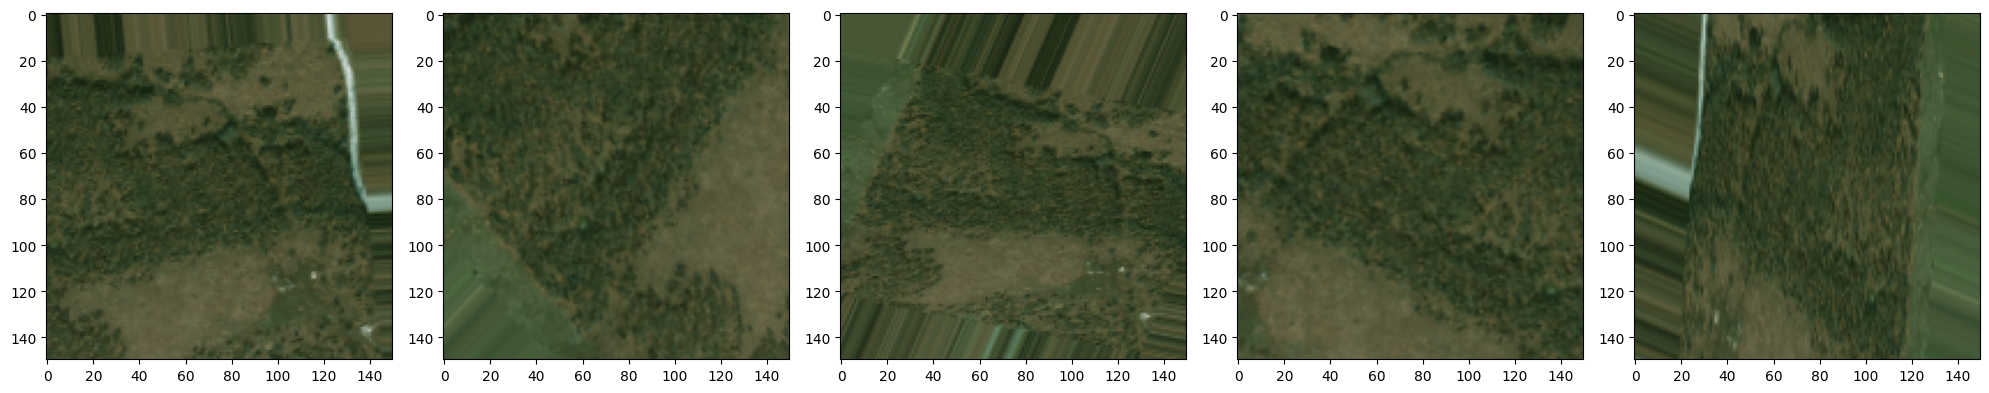

In [137]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [138]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=val_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='binary')

Found 110 images belonging to 2 classes.


In [139]:
model = Sequential()

model.add(Conv2D(32, 3, padding='same', activation='relu', input_shape=(IMG_SHAPE,IMG_SHAPE, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
#model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))

#model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))

In [140]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [141]:
%%time
epochs = 10

history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(train_data_gen.n / float(batch_size))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(val_data_gen.n / float(batch_size)))
)


<timed exec>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/10
11/11 [==============================] - 35s 3s/step - loss: 28.4889 - accuracy: 0.7337 - val_loss: 0.4967 - val_accuracy: 0.8091
Epoch 2/10
11/11 [==============================] - 25s 2s/step - loss: 0.5635 - accuracy: 0.8018 - val_loss: 0.4873 - val_accuracy: 0.8091
Epoch 3/10
11/11 [==============================] - 25s 2s/step - loss: 0.5241 - accuracy: 0.8018 - val_loss: 0.4853 - val_accuracy: 0.8091
Epoch 4/10
11/11 [==============================] - 24s 2s/step - loss: 0.4976 - accuracy: 0.8018 - val_loss: 0.4887 - val_accuracy: 0.8091
Epoch 5/10
11/11 [==============================] - 23s 2s/step - loss: 0.4979 - accuracy: 0.8018 - val_loss: 0.4866 - val_accuracy: 0.8091
Epoch 6/10
11/11 [==============================] - 24s 2s/step - loss: 0.4983 - accuracy: 0.8018 - val_loss: 0.4803 - val_accuracy: 0.8091
Epoch 7/10
11/11 [==============================] - 25s 2s/step - loss: 0.5144 - accuracy: 0.8018 - val_loss: 0.4819 - val_accuracy: 0.8091
Epoch 8/10
11/11 [=

In [131]:
damaged_region = len(glob.glob(os.path.abspath(os.path.join('.', 'dataset', 'train', 'damage', '*'))))
undamaged_region = len(glob.glob(os.path.abspath(os.path.join('.', 'dataset', 'train', 'no_damage', '*'))))
total = damaged_region + undamaged_region
undamaged_region / total

0.8017751479289941

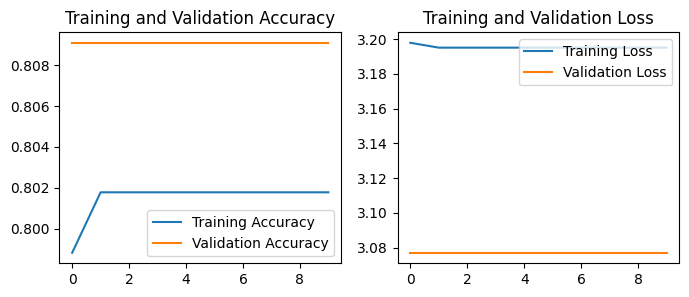

In [132]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Model Testing

In [152]:


import numpy as np

img_path = r'D:\\uoc\\AI4Good-Flood_Detection_Using_Deep_Learning\\dataset\\test\\no_damage\\midwest-flooding_00000010_pre_disaster.png'
img = image.load_img(img_path, target_size=(IMG_SHAPE, IMG_SHAPE))  # IMG_SHAPE used during training
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add the batch dimension

# Preprocess the image
test_image_gen = ImageDataGenerator(rescale=1./255)
processed_img = test_image_gen.flow(img_array, batch_size=1)

model.predict(processed_img)

1/1 [==============================] - 0s 77ms/step


array([[0.2456431, 0.7543569]], dtype=float32)

In [107]:
train_data_gen.class_indices

{'damage': 0, 'no_damage': 1}

# Save model

In [153]:
model.save('floor_model_v1.h5')